#Corporación Favorita Grocery Sales Forecasting
The objective is to predict future sales of items in Favorita grocery stores across different regions of Ecuador. So that Reliable predictions can be helpful to optimize inventory management, prevent stockouts, and improve promotion strategies.

#1- Importing Libraries

In [ ]:
!pip install -q pmdarima numpy==1.26.4

In [ ]:
!pip install -q pmdarima

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import numpy as np

import warnings
# Ignore FutureWarning from the 'sklearn.utils.deprecation' module
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.utils.deprecation')

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2- Data Retreival

In [ ]:
# Select data before April'14
max_date = '2014-04-01'

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6

# Read the CSV file in chunks
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Data/'
for chunk in pd.read_csv(file_path + 'train_Guayas_featureEngg.csv', chunksize=chunk_size):

    chunk_filtered = chunk[(chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)

    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

In [ ]:
df = df_filtered.copy()
print(df.shape)
df.head()

(9437752, 11)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,2.86605
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,2.86605
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,2.86605
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,2.86605
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,2.86605


In [ ]:
#find out all store_nbr ,item_nbr combination
df.groupby(['store_nbr', 'item_nbr']).size().reset_index(name='count')



,store_nbr,item_nbr,count
0,24,96995,454
1,24,99197,454
2,24,103520,454
3,24,105574,454
4,24,105575,454
...,...,...,...
20783,51,2123727,454
20784,51,2123750,454
20785,51,2123775,454
20786,51,2123791,454


# 3- Viewing Time series components

In [ ]:
df['date'] = pd.to_datetime(df['date'])

<Axes: >

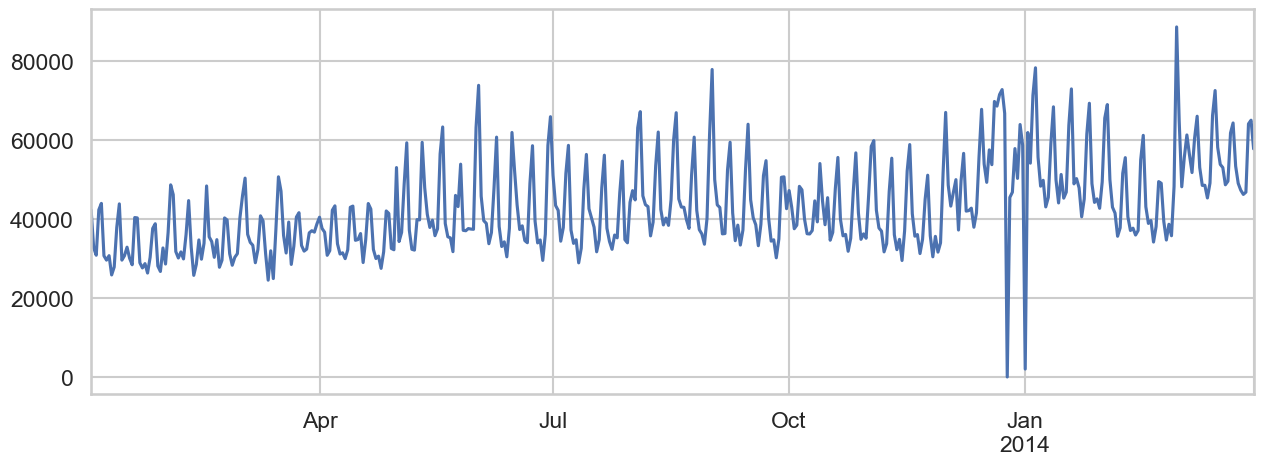

In [ ]:
# Group by date and aggregate sales for each day
df = df.groupby(['date']).sum()['unit_sales'].reset_index()

# Setting an index after the aggregation made
df.set_index('date', inplace=True)


df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

df['unit_sales'].plot()

## 3.1- Seasonal Decomposition
Seasonal decomposition is a powerful technique that breaks down a time series into trend, seasonality, and residuals to reveal underlying patterns. The trend captures the long-term direction, like growth or decline, while seasonality identifies regular, repeating cycles often tied to daily or weekly patterns. The residuals represent the remaining unpredictable fluctuations, allowing for a clearer understanding of what drives the overall data movement.

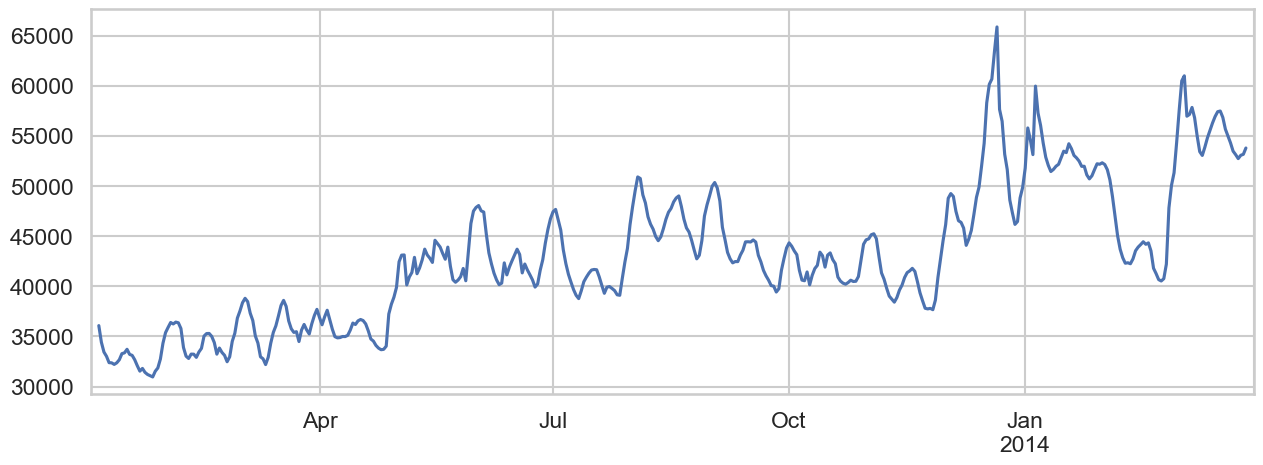

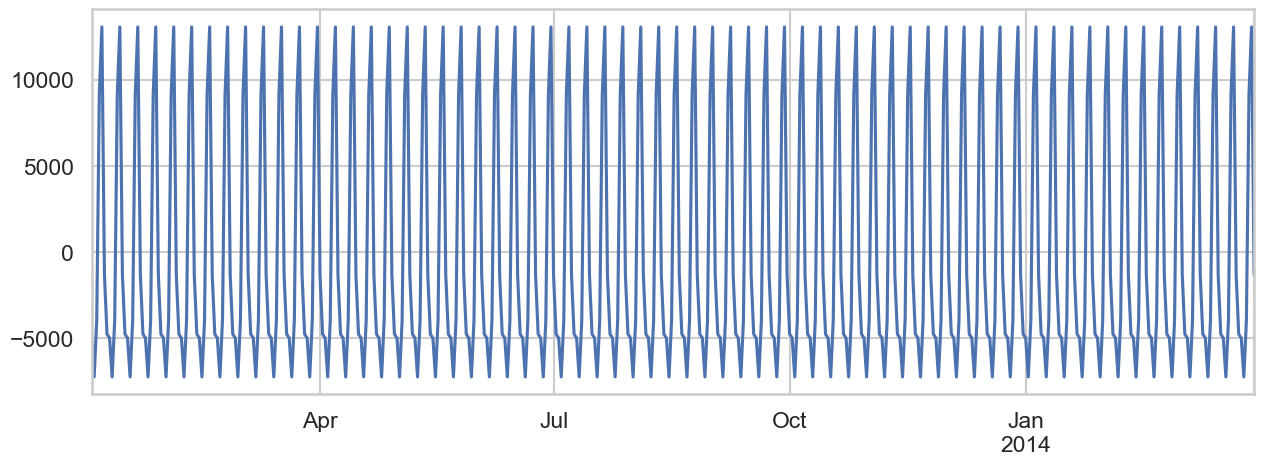

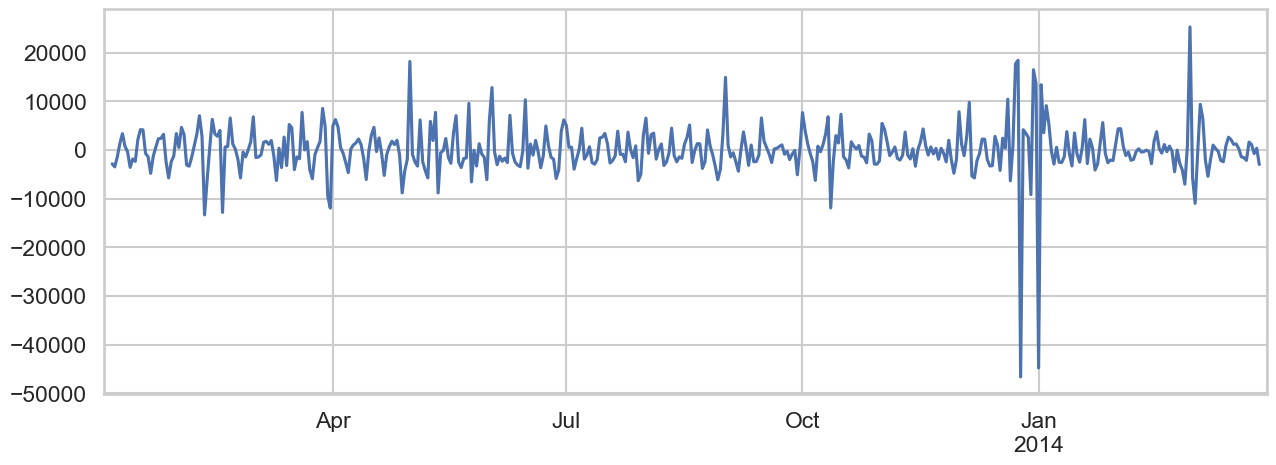

In [ ]:
result = seasonal_decompose(df['unit_sales'])

result.trend.plot()
plt.show()

result.seasonal.plot()
plt.show()

result.resid.plot()
plt.show()

## 3.2- Applying ADF test to check stationarity

In [ ]:
# ADF Test (Augmented Dickey-Fuller Test) Implementation
from statsmodels.tsa.stattools import adfuller

def run_adf(timeseries):
    """Performs Augmented Dickey-Fuller test on a given time series."""
    adf_result = adfuller(timeseries)
    p_value = adf_result[1]
    print(f'P-value is {p_value}')
    if p_value <= 0.05:
        print("The series is stationary (reject H0).")
    else:
        print("The series is non-stationary (fail to reject H0).")

run_adf(df['unit_sales'])

P-value is 0.564926734731174
The series is non-stationary (fail to reject H0).


## 3.2- Integrated Component
This component involves differencing the raw observations to make the time series stationary. Stationarity means that the statistical properties of the time series (like mean and variance) remain constant over time. The 'd' parameter indicates the degree of differencing.


It is clear that we have a trend in our time series. This means we need to difference it. Let's try using order *d = 1*.

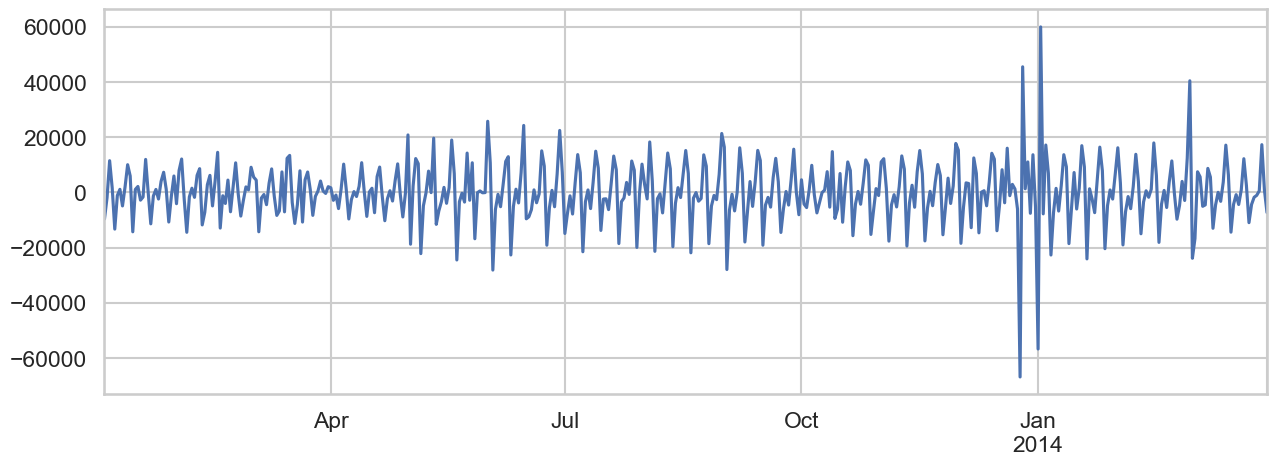

In [ ]:
df.unit_sales.diff().dropna().plot()
plt.show()

## 3.4- AR: Autoregressive
This is the part of the model that uses the relationship between an observation and a number of lagged observations (previous values) to predict future values. The 'p' parameter in ARIMA indicates the order of the AR part, which is the number of lag observations included in the model. For given case it is assumed as p = 5.


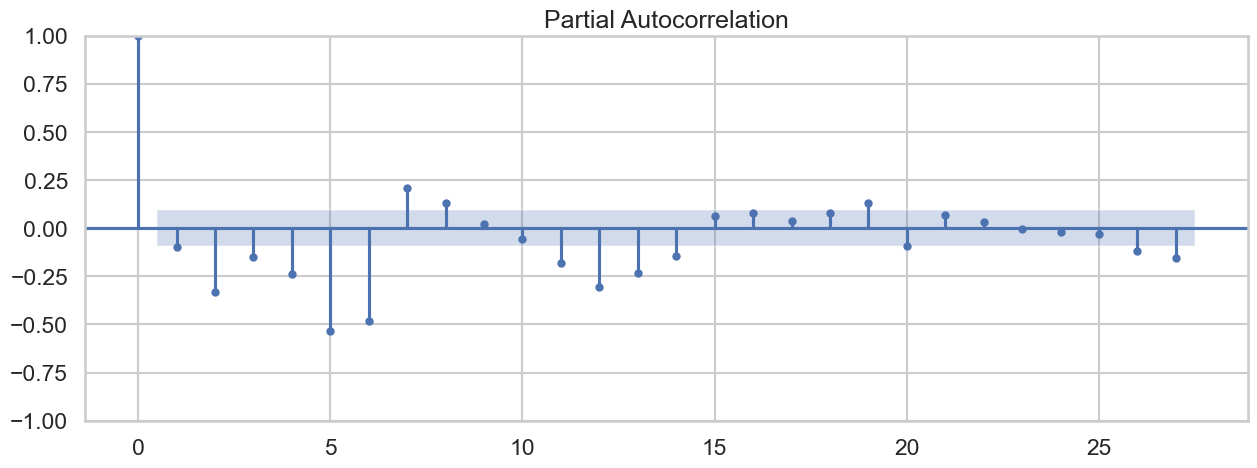

In [ ]:
plot_pacf(df['unit_sales'].diff().dropna())
plt.show()

## 3.5- MA: Moving Average
This part uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. The 'q' parameter indicates the order of the MA part, which is the number of lagged forecast errors included in the model. For given case it is taken as q = 7.




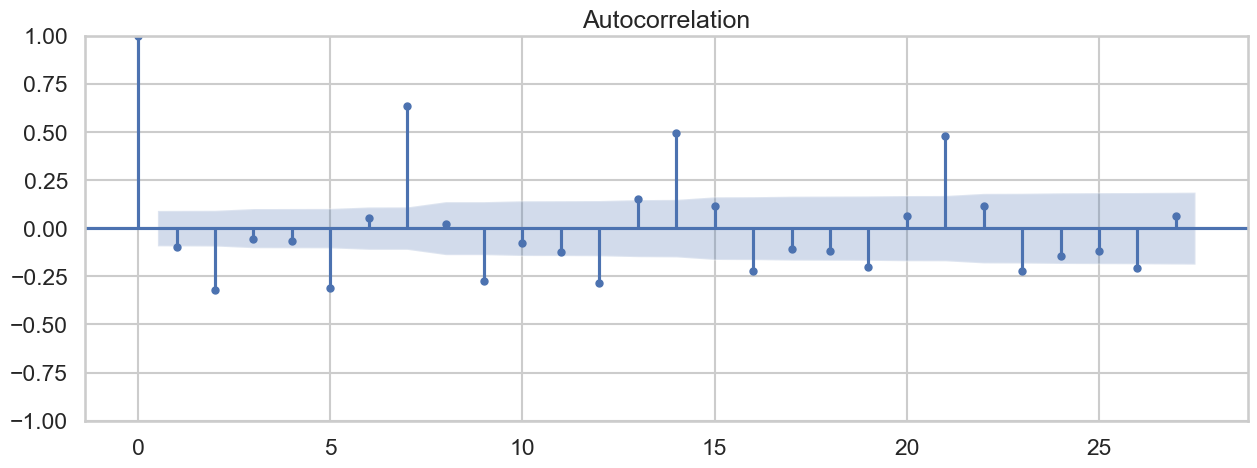

In [ ]:
plot_acf(df['unit_sales'].diff().dropna())
plt.show()

# 4- Classical Model for Time series

## 4.1- ARIMA
The ARIMA model, which stands for Autoregressive Integrated Moving Average, is a statistical model used for time series forecasting. It's a combination of three components:

- p is the order of the Autoregressive (AR) part.
- d is the order of differencing (Integrated part).
- q is the order of the Moving Average (MA) part.

In [ ]:
def model_evaluation(model, test_size = 90, exog=None):
    '''
    This function evaluates the model on a given test size
    '''
    train_predictions = model.predict()
    if exog is not None:
        forecast = model.get_forecast(test_size, exog = df[-test_size:][exog])
        test_predictions = forecast.predicted_mean

    else:
        try:
            test_predictions = model.forecast(test_size)

        except:
            test_predictions = model.predict(test_size)

    print(len(test_predictions))
    mae = mean_absolute_error(df[-test_size:]['unit_sales'], test_predictions)
    r2 = r2_score(df[-test_size:]['unit_sales'], test_predictions)
    print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')


    #plot
    fig, ax = plt.subplots()
    ax.plot(train_predictions, label = 'Train predictions')
    ax.plot(df['unit_sales'], label = 'Input data')
    ax.plot(test_predictions, label = 'Test predictions')
    plt.legend()
    plt.show()



In [ ]:
df.head()

,unit_sales
2013-01-02,42320.0
2013-01-03,32708.0
2013-01-04,30849.0
2013-01-05,42351.0
2013-01-06,43988.0


### 4.1.1 Splitting Train and Test

In [ ]:
#split train and test by considering the indexs lower then '2014-01-01' as train
train, test = df.loc[:'2013-12-31'], df.loc['2014-01-01':]

### 4.1.2 Intializing ARIMA model

In [ ]:
# intitalizing model
model = ARIMA(endog=train,
              order = (5,1,7)) # (AR-I-MA)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                  364
Model:                 ARIMA(5, 1, 7)   Log Likelihood               -3667.570
Date:                Sat, 14 Jun 2025   AIC                           7361.141
Time:                        00:44:04   BIC                           7411.768
Sample:                    01-02-2013   HQIC                          7381.265
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0872      0.270      0.323      0.746      -0.442       0.616
ar.L2         -0.8367      0.208     -4.018      0.000      -1.245      -0.429
ar.L3         -0.2517      0.372     -0.676      0.4

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 4.1.3 Model Forcasting


In [ ]:
forecast = model_fit.get_forecast(steps = 90)
forecast.predicted_mean
forecast.conf_int()

forcasted_unit_sales = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


forecasted_data = pd.DataFrame({'date': pd.date_range(start = '2024-01-01',
                                                      #end = '2024-01-07',
                                                       periods = 90,
                                                       freq = 'D'),
                                'unit_sales': df[-90:]['unit_sales'],
                                'forcasted_unit_sales': forecast.predicted_mean,
                                'Lower_Bound': confidence_intervals.iloc[:,0],
                                'Upper_Bound': confidence_intervals.iloc[:,1]})
forecasted_data.head()

,date,unit_sales,forcasted_unit_sales,Lower_Bound,Upper_Bound
2014-01-01,2024-01-01,2005.868,43049.468147,30990.822344,55108.113949
2014-01-02,2024-01-02,61947.875,43321.515394,30524.409936,56118.620851
2014-01-03,2024-01-03,54187.897,54542.412087,41586.789418,67498.034756
2014-01-04,2024-01-04,71364.655,55549.473689,42492.920340,68606.027039
2014-01-05,2024-01-05,78360.721,58396.370426,45097.057289,71695.683563


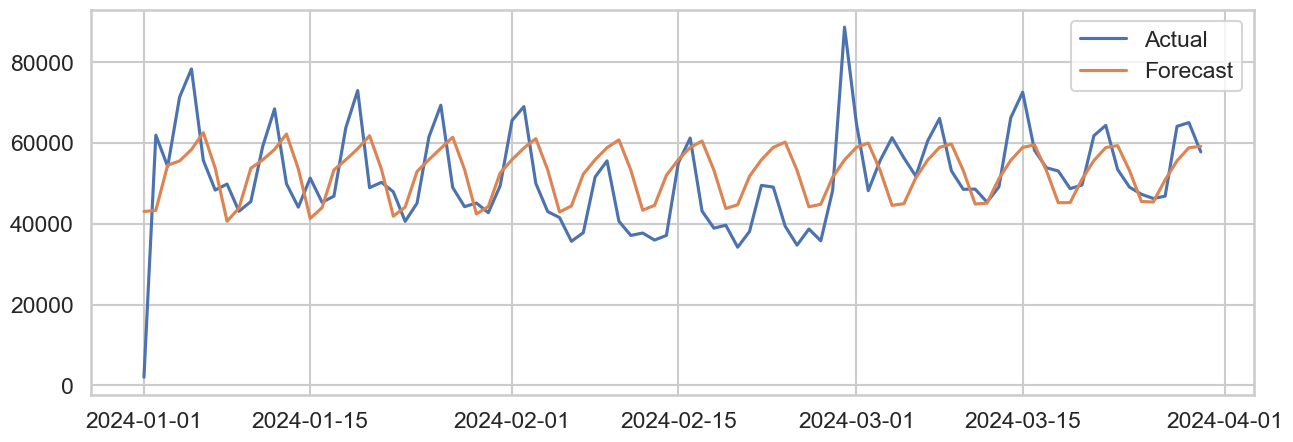

In [ ]:
#plot forecasted_data['unit_sales'] and forecasted_data['forcasted_unit_sales']
plt.figure(figsize=(15,5))
plt.plot(forecasted_data['date'], forecasted_data['unit_sales'], label='Actual')
plt.plot(forecasted_data['date'], forecasted_data['forcasted_unit_sales'], label='Forecast')
plt.legend()
plt.show()


### 4.1.4 Model Evaluation

90
R2 score 0.2
Mean absolute error 8343.39


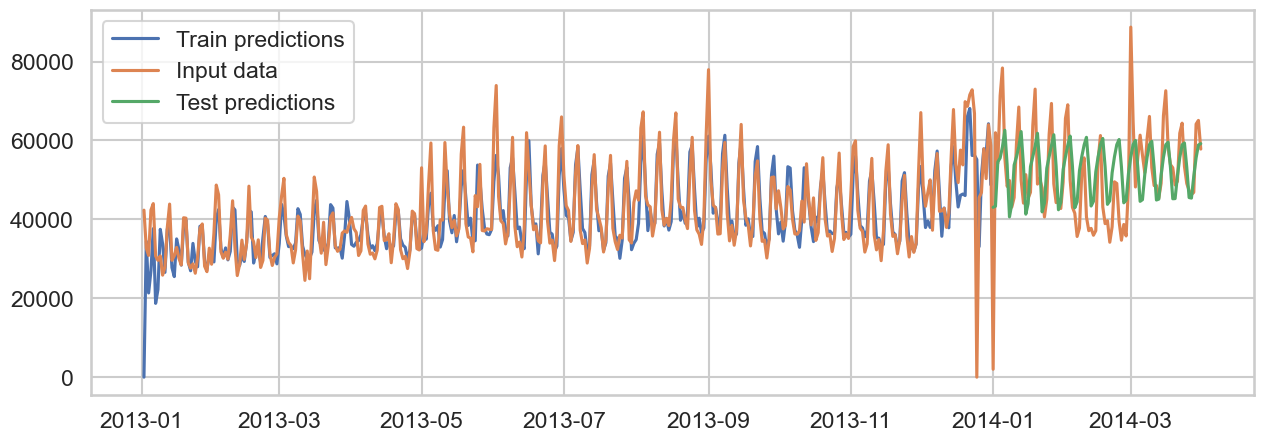

In [ ]:
model_evaluation(model_fit)


In [ ]:
#calculating Bias
forecasted_data['Bias'] = forecasted_data['unit_sales'] - forecasted_data['forcasted_unit_sales']

#Bias, MAD, rMAD
Bias = forecasted_data['Bias'].mean()
MAD = forecasted_data['Bias'].abs().mean()
rMAD = forecasted_data['Bias'].abs().mean()/forecasted_data['unit_sales'].mean()

print(f'Bias: {Bias}\nMAD: {MAD}\nrMAD: {rMAD}')


Bias: -1473.570898694353
MAD: 8343.38845074523
rMAD: 0.16297260924712656


## 4.2- SARIMA + autoarima
SARIMA stands for Seasonal Autoregressive Integrated Moving Average. It is an extension of the ARIMA model that explicitly handles time series with a seasonal component. A SARIMA model is typically denoted as SARIMA(p, d, q)(P, D, Q, m).
- p: Order of the non-seasonal Autoregressive (AR) part.
- d: Order of non-seasonal differencing (Integrated part).
- q: Order of the non-seasonal Moving Average (MA) part.

In addition to these, SARIMA includes seasonal components denoted as (P, D, Q, m):

- P: Order of the seasonal Autoregressive (AR) part.
- D: Order of seasonal differencing (Seasonal Integrated part).
- Q: Order of the seasonal Moving Average (MA) part.
- m: The number of time steps for a single seasonal period (e.g.,for given case 7 for daily data with weekly seasonality).

In [ ]:
# Applying model
model = auto_arima(train["unit_sales"],
                         start_p=1, start_q=1,
                         test='adf',
                         max_p=25, max_q=25,
                         m=7, #7 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=0,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

In [ ]:
# finding best model
model

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True)

90
R2 score 0.23
Mean absolute error 8369.54


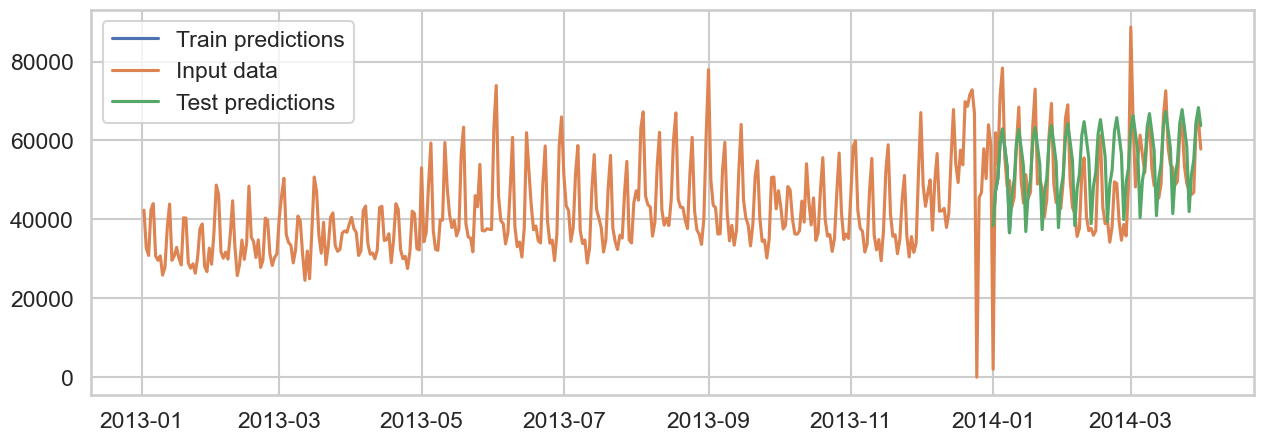

In [ ]:
# evaluating best model
model_evaluation(model)

### 4.1.3 Model Forcasting


In [ ]:
model.predict(steps = 90)

2014-01-01    38380.664974
2014-01-02    47083.689525
2014-01-03    50247.637973
2014-01-04    59657.327534
2014-01-05    62895.257503
2014-01-06    58113.700743
2014-01-07    53239.135650
2014-01-08    36613.085862
2014-01-09    45963.641960
2014-01-10    49590.831940
Freq: D, dtype: float64

In [ ]:
forecast = model.predict(n_periods = 90)


forecasted_data = pd.DataFrame({'date': pd.date_range(start = '2024-01-01',
                                                      #end = '2024-01-07',
                                                       periods = 90,
                                                       freq = 'D'),
                                'unit_sales': df[-90:]['unit_sales'],
                                'forcasted_unit_sales': forecast,
                                })
forecasted_data.head()

,date,unit_sales,forcasted_unit_sales
2014-01-01,2024-01-01,2005.868,38380.664974
2014-01-02,2024-01-02,61947.875,47083.689525
2014-01-03,2024-01-03,54187.897,50247.637973
2014-01-04,2024-01-04,71364.655,59657.327534
2014-01-05,2024-01-05,78360.721,62895.257503


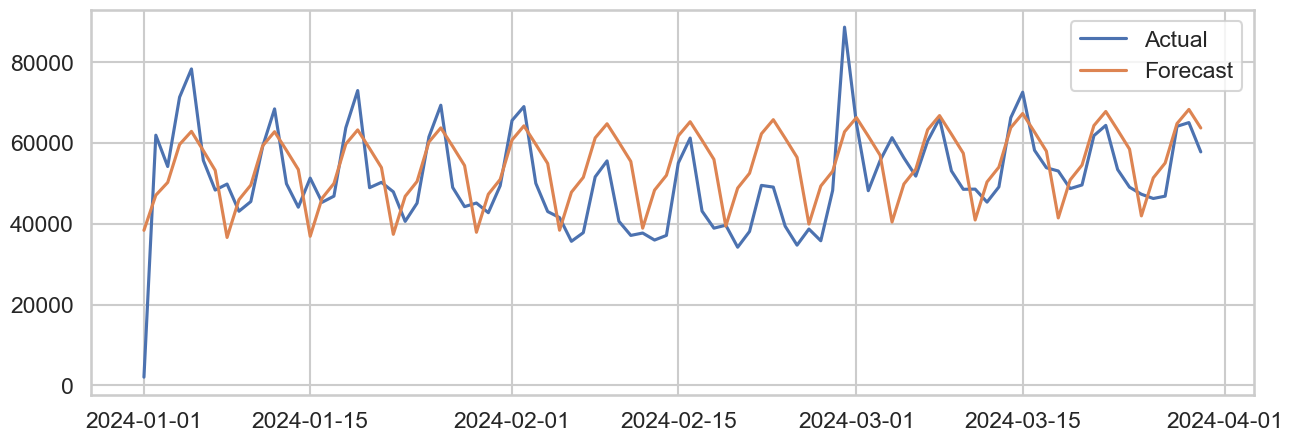

In [ ]:
#plot forecasted_data['unit_sales'] and forecasted_data['forcasted_unit_sales']
plt.figure(figsize=(15,5))
plt.plot(forecasted_data['date'], forecasted_data['unit_sales'], label='Actual')
plt.plot(forecasted_data['date'], forecasted_data['forcasted_unit_sales'], label='Forecast')
plt.legend()
plt.show()


In [ ]:
#calculating Bias
forecasted_data['Bias'] = forecasted_data['unit_sales'] - forecasted_data['forcasted_unit_sales']

#Bias, MAD, rMAD
Bias = forecasted_data['Bias'].mean()
MAD = forecasted_data['Bias'].abs().mean()
rMAD = forecasted_data['Bias'].abs().mean()/forecasted_data['unit_sales'].mean()

print(f'Bias: {Bias}\nMAD: {MAD}\nrMAD: {rMAD}')


Bias: -3561.766636575413
MAD: 8369.537222408653
rMAD: 0.16348337697318335


5- SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors)
---

In [ ]:
# considering oil as exogenous factor
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Data/'
#df_oil = pd.read_csv('/content/drive/MyDrive/Projects/Timeseries_project/data/oil.csv')
df_oil = pd.read_csv(file_path+'oil.csv')
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil.set_index('date', inplace=True)
df_oil.index = pd.DatetimeIndex(df_oil.index.values, freq=df_oil.index.inferred_freq)
#fill nulls 'dcoilwtico' with mean of the coulmn
df_oil['dcoilwtico'].fillna(df_oil['dcoilwtico'].mean(), inplace=True)



df_oil.info()





<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: B
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1218 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


/var/folders/c8/sh5pt5vd6l18mnnz089s6hd80000gn/T/ipykernel_40283/3997145442.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_oil['dcoilwtico'].fillna(df_oil['dcoilwtico'].mean(), inplace=True)


In [ ]:
df_oil.head()
#left join df and df_oil
df = df.join(df_oil, how='left')

fillnull = df['dcoilwtico'].mean()
df['dcoilwtico'].fillna(fillnull, inplace=True)
df.head()


/var/folders/c8/sh5pt5vd6l18mnnz089s6hd80000gn/T/ipykernel_40283/2259560747.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dcoilwtico'].fillna(fillnull, inplace=True)


,unit_sales,dcoilwtico
2013-01-02,42320.0,93.140000
2013-01-03,32708.0,92.970000
2013-01-04,30849.0,93.120000
2013-01-05,42351.0,97.085889
2013-01-06,43988.0,97.085889


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 454 entries, 2013-01-02 to 2014-03-31
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unit_sales  454 non-null    float64
 1   dcoilwtico  454 non-null    float64
dtypes: float64(2)
memory usage: 26.8 KB


### 5.1- Tain and test split making



In [ ]:

#split train and test by considering the indexs lower then '2014-01-01' as train
train, test = df.loc[:'2013-12-31'], df.loc['2014-01-01':]

### 5.2- Intializing and applying model

In [ ]:
order = (1,0,1)
seasonal_order = (0,1,1,7)
sarimax_model = SARIMAX(train['unit_sales'], order = order,
                       seasonal_order=seasonal_order,
                        exog = train['dcoilwtico'])


In [ ]:
sarimax_model_fit = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94025D+00    |proj g|=  2.77995D-02

At iterate    5    f=  9.93710D+00    |proj g|=  1.61820D-03

At iterate   10    f=  9.93703D+00    |proj g|=  7.02252D-04


 This problem is unconstrained.



At iterate   15    f=  9.93637D+00    |proj g|=  8.47537D-03

At iterate   20    f=  9.92038D+00    |proj g|=  1.36939D-02

At iterate   25    f=  9.91993D+00    |proj g|=  4.27415D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     27      1     0     0   4.274D-05   9.920D+00
  F =   9.9199312233096819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### 5.3- Model Evaluation

90
R2 score 0.38
Mean absolute error 7137.65


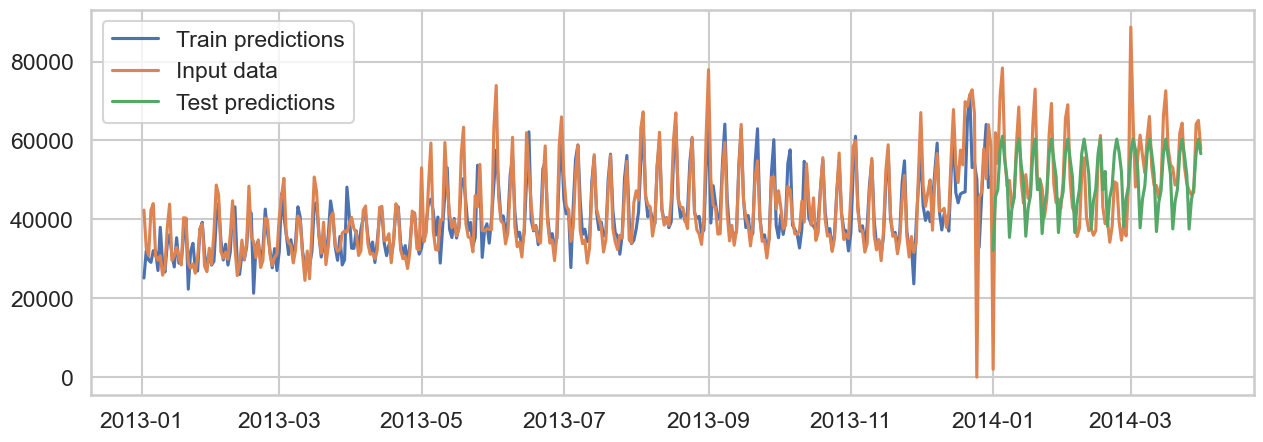

In [ ]:
model_evaluation(sarimax_model_fit, exog='dcoilwtico')

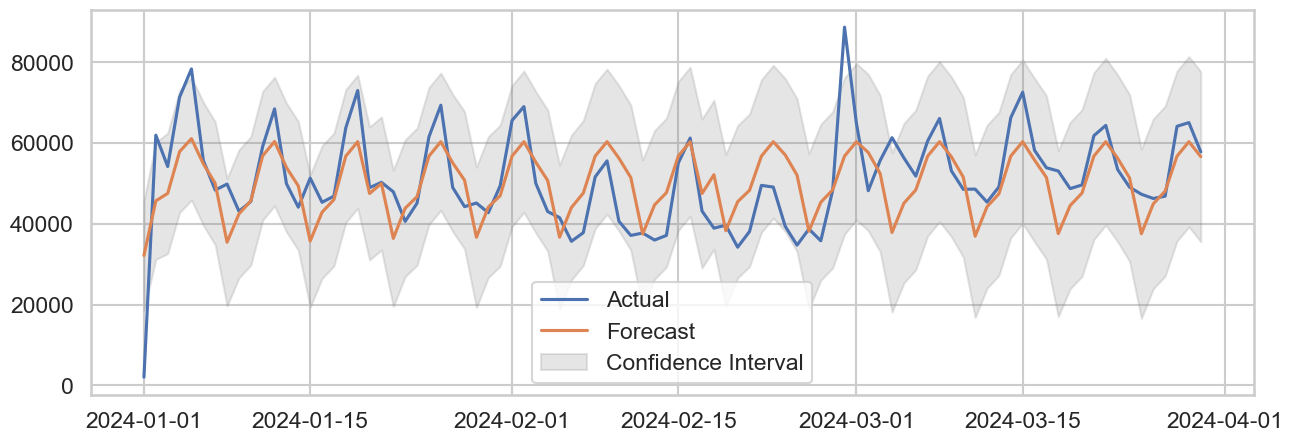

Bias: 989.7333692828392
MAD: 7137.6470245909695
rMAD: 0.1394206881712045


In [ ]:
#calculating Bias
forecast = sarimax_model_fit.get_forecast(steps=90, exog=test['dcoilwtico'])
forecasted_data = pd.DataFrame({'date': pd.date_range(start = '2024-01-01',
                                                      #end = '2024-01-07',
                                                       periods = 90,
                                                       freq = 'D'),
                                'unit_sales': df[-90:]['unit_sales'],
                                'forcasted_unit_sales': forecast.predicted_mean,
                                'Lower_Bound': forecast.conf_int().iloc[:,0],
                                'Upper_Bound': forecast.conf_int().iloc[:,1]})
forecasted_data.head()
#plot forecasted_data['unit_sales'] and forecasted_data['forcasted_unit_sales']
plt.figure(figsize=(15,5))
plt.plot(forecasted_data['date'], forecasted_data['unit_sales'], label='Actual')
plt.plot(forecasted_data['date'], forecasted_data['forcasted_unit_sales'], label='Forecast')
plt.fill_between(forecasted_data['date'], forecasted_data['Lower_Bound'], forecasted_data['Upper_Bound'], color='gray', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()
#calculating Bias
forecasted_data['Bias'] = forecasted_data['unit_sales'] - forecasted_data['forcasted_unit_sales']

#Bias, MAD, rMAD
Bias = forecasted_data['Bias'].mean()
MAD = forecasted_data['Bias'].abs().mean()
rMAD = forecasted_data['Bias'].abs().mean()/forecasted_data['unit_sales'].mean()

print(f'Bias: {Bias}\nMAD: {MAD}\nrMAD: {rMAD}')